In [1]:
# Importing The basic necessarry Library.

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
#for tensorflow > 1.10  import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense, Input, InputLayer, Flatten

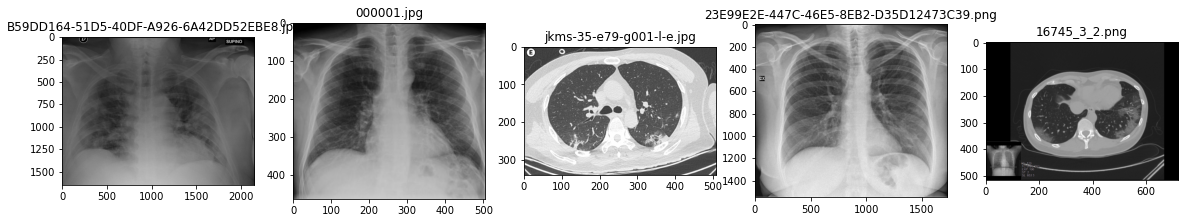

In [4]:
# We want to see some random imahes from our data_base 
plt.figure(figsize=(20,20))
#test_folder=r'CV\Intel_Images\seg_train\seg_train\forest'
import random
img_folder =  "Capstone_Data_Base"
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# The Above images are randomly generated by using file = random.choice(os.listdir(img_folder))

In [5]:
!pip install imutils

In [6]:
# import the necessary packages for the project.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [7]:


dataset_path = "Capstone_Data_Base"

In [8]:
# This path goes to covid folder which consist of the images which are Covid -19 Positive.
covid_dataset_path = 'dataset_path_POS'

In [9]:
# path to the metadata 
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)


In [10]:

# loop.
for (i, row) in df.iterrows():
    # This Codes meet 2 requirement .
    # 1 .  Row get called called for  Finding and and filter the Covid Cases.
    # 2.  filter ON "PA"
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file  not exist
    
    if not os.path.exists(imagePath):
        continue

    #  construct the path
    
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [11]:
pneumonia_dataset_path ='Out_PUT'

In [12]:
samples = 25

In [13]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sampleed the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    
    shutil.copy2(imagePath, outputPath)

In [14]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [15]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

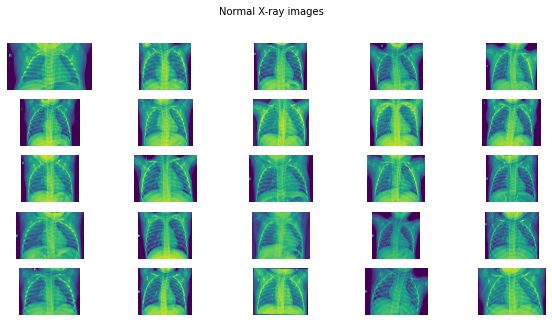

In [16]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

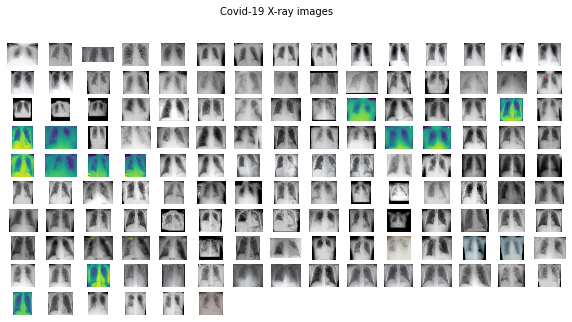

In [27]:
plots_from_files(covid_images, rows=10, maintitle="Covid-19 X-ray images")

In [18]:
# initialize the initial learning rate, number of epochs to train BS =  batch size () 
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [19]:
# list of images  the dataset directory and initialize
# images and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop 
for imagePath in imagePaths:
    # extract the class label 
    label = imagePath.split(os.path.sep)[-2]
    # load the image
    # swap color channels
    # resize it to be a fixed
    # 224*224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels list
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [20]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [21]:
# VGG16 network
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# FC model on top of the base model 
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [22]:
# compile  model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
16/16 [==============================] - 15s 958ms/step - loss: 0.5171 - accuracy: 0.7742 - val_loss: 0.4728 - val_accuracy: 0.8529
Epoch 2/10
16/16 [==============================] - 16s 980ms/step - loss: 0.5049 - accuracy: 0.8468 - val_loss: 0.3752 - val_accuracy: 0.8529
Epoch 3/10
16/16 [==============================] - 16s 1s/step - loss: 0.3986 - accuracy: 0.8468 - val_loss: 0.3097 - val_accuracy: 0.8529
Epoch 4/10
16/16 [==============================] - 16s 1s/step - loss: 0.3374 - accuracy: 0.8548 - val_loss: 0.2755 - val_accuracy: 0.8529
Epoch 5/10
16/16 [==============================] - 16s 1s/step - loss: 0.3344 - accuracy: 0.8387 - val_loss: 0.2434 - val_accuracy: 0.8824
Epoch 6/10
16/16 [==============================] - 16s 1s/step - loss: 0.2790 - accuracy: 0.8952 - val_loss: 0.2198 - val_accuracy: 0.8824
Epoch 7/10
16/16 [==========

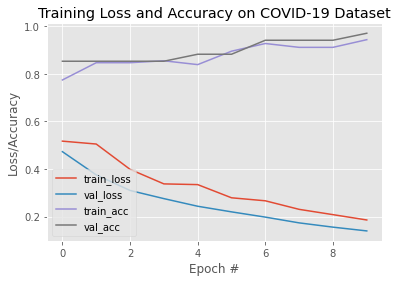

In [23]:
# loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [24]:
# make predictions classification report
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.97      1.00      0.98        29
      normal       1.00      0.80      0.89         5

    accuracy                           0.97        34
   macro avg       0.98      0.90      0.94        34
weighted avg       0.97      0.97      0.97        34



In [25]:
# accuracy, sensitivity, and specificity 
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
#  confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[29  0]
 [ 1  4]]
acc: 0.9706
sensitivity: 1.0000
specificity: 0.8000
